In [2]:
import scanpy as sc
import matplotlib as mpl
import pandas as pd
import matplotlib.pyplot as plt
import bbknn
import scipy.stats
import numpy as np
import seaborn as sns
import gffutils
import re

In [3]:
import sys
sys.path.insert(0, "../lib")

In [4]:
import script.scanpy as sc_utils

In [5]:
import importlib
importlib.reload(sc_utils)

<module 'script.scanpy' from '../lib/script/scanpy.py'>

In [6]:
mpl.font_manager.fontManager.addfont("../arial.ttf")
mpl.font_manager.fontManager.addfont("../Arial Italic.ttf")
mpl.font_manager.fontManager.addfont("../arialbd.ttf")

In [7]:
mpl.rcParams["figure.figsize"] = (12, 12)
mpl.rcParams["font.family"] = "Arial"
mpl.rcParams["pdf.fonttype"] = 42
pd.set_option("display.max_rows", 1000)

## COVID-only plots (Figure 6)

In [8]:
covid = sc.read_h5ad("../data/04dataset/04obj-covid.h5ad")

In [9]:
sorted(covid.obs.celltype.unique())

['AT2, AT1 cells',
 'B cells',
 'CD4 CM T cells',
 'CD4 cytotoxic T cells',
 'CD4 proliferating T cells',
 'CD8 cytotoxic T cells',
 'CD8 cytotoxic TRM T cells',
 'CD8 proliferating T cells',
 'Ciliated cells',
 'Club, Basal cells',
 'DC1',
 'DC2',
 'Infected AT2, AT1 cells',
 'Ionocytes',
 'Mast cells',
 'Migratory DC',
 'Mixed myeloid',
 'MoAM1',
 'MoAM2',
 'MoAM3',
 'MoAM4',
 'Plasma cells',
 'Proliferating AM',
 'TRAM1',
 'TRAM2',
 'Treg',
 'iNKT cells',
 'pDC']

In [10]:
prev_colors = pd.read_csv("../02preprint/10obj-colors.tsv", sep="\t", index_col=0)

In [11]:
palette = prev_colors.reindex(covid.obs.celltype.unique().astype(str)).sort_index()

In [12]:
prev_colors

,color
metadataValue,
"AT2, AT1 cells",#1f77b4
CD4 T cells,#ff7f0e
CD8 T cells,#279e68
Ciliated cells,#d62728
"Club, Basal cells",#aa40fc
DC1,#8c564b
DC2,#e377c2
Ionocytes,#b5bd61
Migratory DC,#17becf


In [15]:
palette

,color
metadataValue,
"AT2, AT1 cells",#1f77b4
B cells,#aec7e8
CD4 CM T cells,#ff7f0e
CD4 cytotoxic T cells,#1f77b4
CD4 proliferating T cells,#c5b0d5
CD8 cytotoxic T cells,#f7b6d2
CD8 cytotoxic TRM T cells,#279e68
CD8 proliferating T cells,#c49c94
Ciliated cells,#d62728


In [14]:
palette.loc["Plasma cells", "color"] = prev_colors.color["Plasma, B cells"]
palette.loc["Proliferating AM", "color"] = prev_colors.color["MoAM5"]
palette.loc["CD8 proliferating T cells", "color"] = prev_colors.color["Proliferating CD8 T cells"]
palette.loc["CD4 proliferating T cells", "color"] = prev_colors.color["Proliferating CD4 T cells"]
palette.loc["Treg", "color"] = prev_colors.color["Tregs"]
palette.loc["CD4 CM T cells", "color"] = prev_colors.color["CD4 T cells"]
palette.loc["CD8 cytotoxic TRM T cells", "color"] = prev_colors.color["CD8 T cells"]
palette.loc["CD8 cytotoxic T cells", "color"] = prev_colors.color["TRAM1"]
palette.loc["CD4 cytotoxic T cells", "color"] = prev_colors.color["AT2, AT1 cells"]
palette.loc["iNKT cells", "color"] = prev_colors.color["MoAM3"]
palette.loc["Mixed myeloid", "color"] = palette.color["CD4 CM T cells"]
palette.loc["Mast cells", "color"] = palette.color["MoAM4"]
palette.loc["B cells", "color"] = palette.color["MoAM1"]
palette.loc["Infected AT2, AT1 cells", "color"] = palette.color["CD4 CM T cells"]

In [16]:
palette.to_csv("05palette-colors.tsv", index_label="metadataValue", sep="\t", header=True)

### Figure 5A (UMAP)

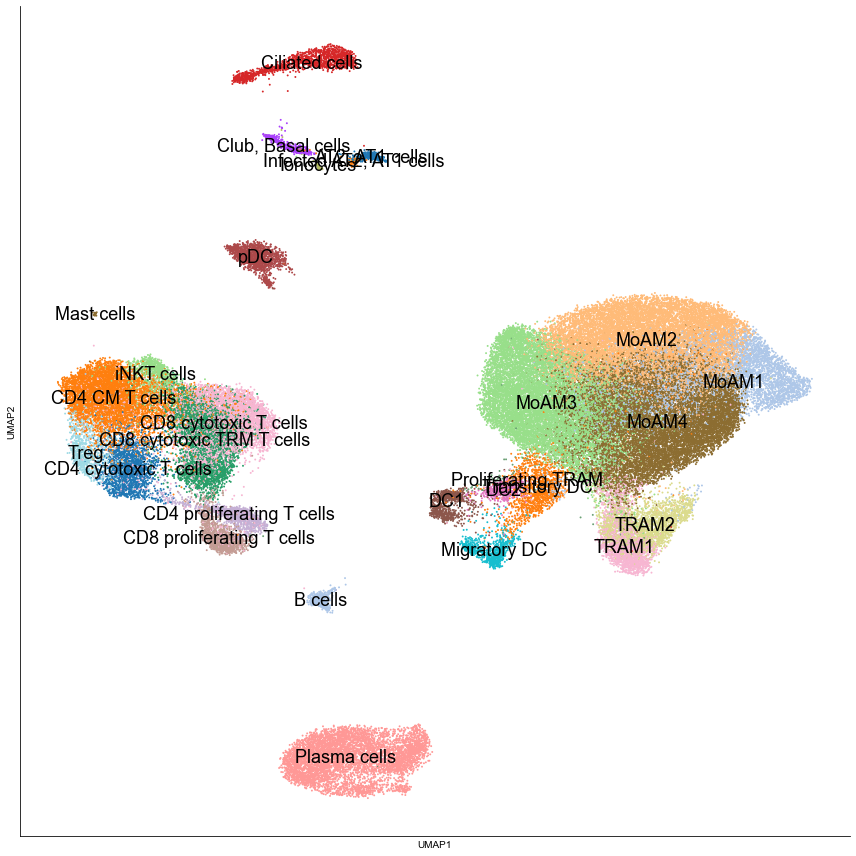

In [24]:
ax = sc.pl.umap(
    covid, 
    color="celltype", 
    size=15, 
    legend_loc="on data", 
    show=False, 
    legend_fontsize=18, 
    legend_fontweight="normal",
    palette=list(palette.fillna("#444444").color)
)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_title("")
ax.figure.tight_layout()
ax.figure.savefig("07plots/5A_umap.pdf")

### Figure 5B (heatmap of genes for macrophages)

In [55]:
mac_clusters = covid.obs.celltype[covid.obs.celltype.str.match("MoAM|TRAM")].astype(str).unique()

In [56]:
ds_macs = covid[covid.obs.celltype.isin(mac_clusters), :].copy()

In [62]:
ds_macs.obs["cluster_p"] = ds_macs.obs.celltype.astype(str) + ", pt." + ds_macs.obs.patient.astype(str)

In [63]:
cluster_counts = ds_macs.obs.cluster_p.value_counts()

In [64]:
low_counts = cluster_counts.index[cluster_counts < 10]

In [65]:
ds_macs = ds_macs[~ds_macs.obs.cluster_p.isin(low_counts), :]

In [66]:
genes_of_i = """G0S2
CXCL8
IL1B
CCL20
CCL3
CCL4
CXCL9
CXCL10
CXCL11
IL1RN
C15orf48
SPP1
CCL8
TNFSF10
DEFB1
IL27
CALHM6
PLTP
RNASE1
STAB1
CCL2
MAFB
CD14
CSF1R
ITGAM
VCAN
CCL18
TREM2
MRC1
C1QA
FBP1
OLR1
MARCO
MCEMP1
MSR1
FABP4
RBP4
INHBA""".split("\n")

In [71]:
markers_expr = []
ifn_scores = []
clusters = sorted(ds_macs.obs.cluster_p.unique())
for g in clusters:
    mean_exp = ds_macs.raw.X[(ds_macs.obs.cluster_p == g).values, :][:, ds_macs.var_names.isin(genes_of_i)].mean(axis=0).A.reshape(-1)
    markers_expr.append(mean_exp)

for g in clusters:
    mean_exp = ds_macs.obs.loc[(ds_macs.obs.cluster_p == g).values, ["IFNA Response", "IFNG Response"]].mean(axis=0).values
    ifn_scores.append(mean_exp)

In [73]:
markers_expr = pd.DataFrame(markers_expr, columns=ds_macs.var_names[ds_macs.var_names.isin(genes_of_i)], index=clusters)

In [74]:
ifn_scores = pd.DataFrame(ifn_scores, columns=["IFNA Response", "IFNG Response"], index=clusters)

In [77]:
total_expr = pd.concat([markers_expr, ifn_scores], axis=1)

In [79]:
total_expr = (total_expr - total_expr.min()) / (total_expr.max() - total_expr.min())

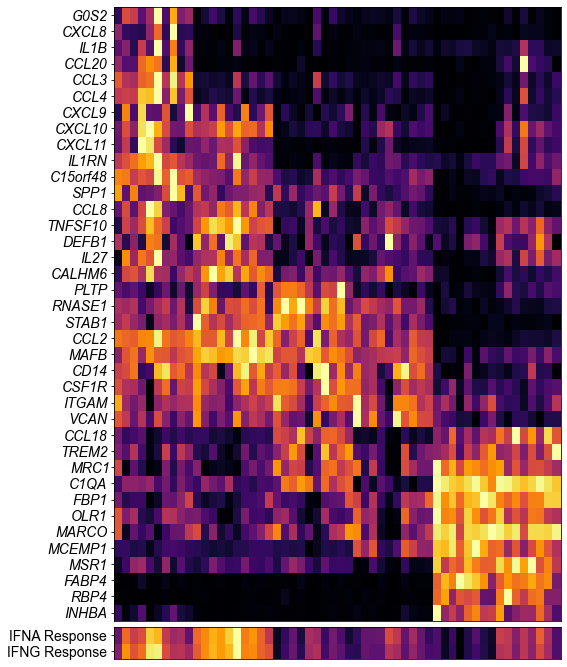

In [88]:
fig, axes = plt.subplots(
    nrows=2, 
    sharex=True, 
    figsize=(8, 12), 
    gridspec_kw={
        "height_ratios": [len(genes_of_i), 2],
        "hspace": 0.02
    }
)
axes[0].pcolormesh(total_expr.loc[:, reversed(genes_of_i)].T.to_numpy(), cmap="inferno")
axes[0].set_yticks(pd.Series(range(len(genes_of_i))) + 0.5)
axes[0].set_yticklabels(
    reversed(genes_of_i), 
    fontstyle="italic",
    fontsize=14
)
troublemaker = axes[0].yaxis.get_majorticklabels()[9]
troublemaker.set_x(troublemaker._x + 0.006)
# troublemaker.set_y = lambda y: mpl.text.Text.set_y(troublemaker, y + 0)
axes[0].tick_params(bottom=False, labelbottom=False)

axes[1].pcolormesh(total_expr.loc[:, ["IFNG Response", "IFNA Response"]].T.to_numpy(), cmap="inferno")
axes[1].set_yticks([0.5, 1.5])
axes[1].set_yticklabels(["IFNG Response", "IFNA Response"], fontsize=14)
axes[1].tick_params(bottom=False, labelbottom=False)

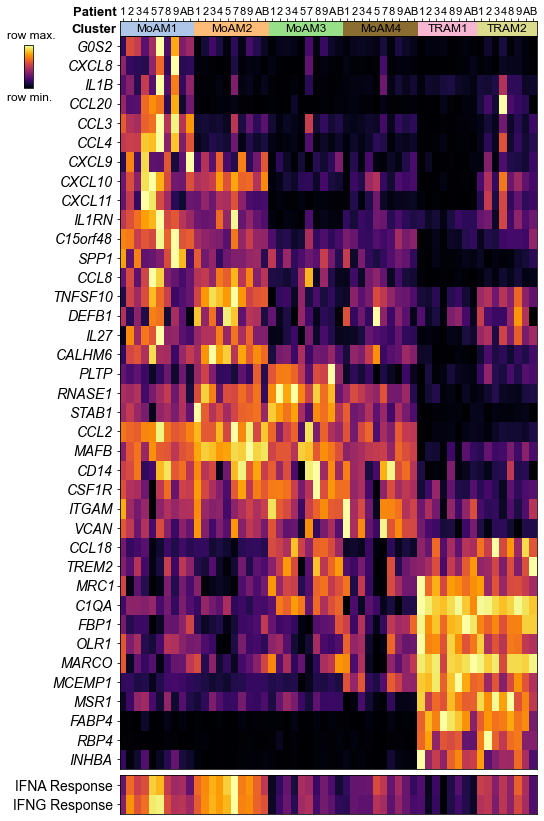

In [89]:
ax0bbox = axes[0].get_position()
labs = fig.add_axes((ax0bbox.x0, ax0bbox.y1, ax0bbox.width, 0.018), sharex=axes[0])
labs.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False, top=True, labeltop=True)
clusters = pd.Series(total_expr.index.str.split(",")).apply(lambda x: x[0]).value_counts().sort_index()
pats = pd.Series(total_expr.index.str.split(",")).apply(lambda x: x[1][4:])
s = 0
for i, n in enumerate(clusters.index):
    w = clusters[n]
    labs.add_patch(mpl.patches.Rectangle(
        (s, 0), 
        w, 
        1, 
        facecolor=palette.color[n]
    ))
    labs.annotate(
        n, 
        (w / 2 + s, 0.45),
        ha="center",
        va="center",
        color="black",
        fontsize=12
    )
    s += w
labs.set_xticks(pd.Series(range(pats.size)) + 0.5)
labs.set_xticklabels(pats), fontsize=11)
labs.tick_params(pad=0)
labs.annotate("Patient", (-0.4, 1.3), annotation_clip=False, ha="right", fontweight="bold", fontsize=13)
labs.annotate("Cluster", (-0.4, 0.2), annotation_clip=False, ha="right", fontweight="bold", fontsize=13)

cax = fig.add_axes((0.13, 0.82, 0.015, 0.05))
cax = fig.colorbar(
    mpl.cm.ScalarMappable(norm=None, cmap="inferno"),
    cax=cax,
    ticks=[]
)
cax.ax.annotate("row min.", (-2, -0.1), va="top", annotation_clip=False, fontsize=12)
cax.ax.annotate("row max.", (-2, 1.1), va="bottom", annotation_clip=False, fontsize=12)

available_height = axes[1].get_position().x0 + 0.02
proportions = [len(genes_of_i), 2]
move = 0
for i, ax in enumerate(fig.axes):
    p = ax.get_position()
    if i == 3:
        p.x0 -= 0.05
        p.x1 -= 0.05
    else:
        p.x0 += 0.12
        p.x1 += 0.07
    p.y0 += 0.06
    p.y1 += 0.06
    if i < len(proportions):
        p.y1 -= move
        move += available_height / np.sum(proportions) * proportions[i]
        p.y0 -= move
    ax.set_position(p)

fig.savefig("07plots/5B_mac_markers_v2.pdf")
fig

## Figure 5X TRAM markers

In [16]:
tram_clusters = covid.obs.celltype[covid.obs.celltype.str.match("TRAM")].astype(str).unique()

In [17]:
ds_tram = covid[covid.obs.celltype.isin(tram_clusters), :].copy()

In [18]:
ds_tram.obs.patient = ds_tram.obs.patient.cat.set_categories(covid.obs.patient.cat.categories)

In [19]:
ds_tram.obs["cluster_p"] = ds_tram.obs.celltype.astype(str) + ", pt." + ds_tram.obs.patient.astype(str)

In [20]:
cluster_counts = ds_tram.obs.cluster_p.value_counts()
low_counts = cluster_counts.index[cluster_counts < 10]

In [21]:
ds_tram = ds_tram[~ds_tram.obs.cluster_p.isin(low_counts), :]

In [22]:
genes_of_i = """NFE2
CD101
DDIT4
ICAM4
APOBEC3A
DDX58
NFKB2
ATF3
DDIT3
CD40
CD274""".split("\n")

cytokines = [
    "IL1B", 
    "CCL3", 
    "CCL4", 
    "CCL20",
    "CXCL9",
    "CXCL10", 
    "CXCL11", 
    "TNFSF10", 
    "DEFB1",
    "IL1RN", 
    "IL27", 
    "CCL8", 
    "IL4I1",
    "IL15RA", 
    "CCL3L1", 
    "CCL4L2", 
    "CCL18"
]

In [23]:
markers_expr = []
ifn_scores = []
all_genes = genes_of_i + cytokines
clusters = sorted(ds_tram.obs.cluster_p.unique())
for g in clusters:
    mean_exp = ds_tram.raw.X[(ds_tram.obs.cluster_p == g).values, :][:, ds_tram.var_names.isin(all_genes)].mean(axis=0).A.reshape(-1)
    markers_expr.append(mean_exp)

for g in clusters:
    mean_exp = ds_tram.obs.loc[(ds_tram.obs.cluster_p == g).values, ["IFNA Response", "IFNG Response"]].mean(axis=0).values
    ifn_scores.append(mean_exp)

In [24]:
markers_expr = pd.DataFrame(
    markers_expr, 
    columns=ds_tram.var_names[ds_tram.var_names.isin(all_genes)], 
    index=clusters
)

In [25]:
ifn_scores = pd.DataFrame(ifn_scores, columns=["IFNA Response", "IFNG Response"], index=clusters)

In [26]:
total_expr = pd.concat([markers_expr, ifn_scores], axis=1)

In [27]:
total_expr = (total_expr - total_expr.min()) / (total_expr.max() - total_expr.min())

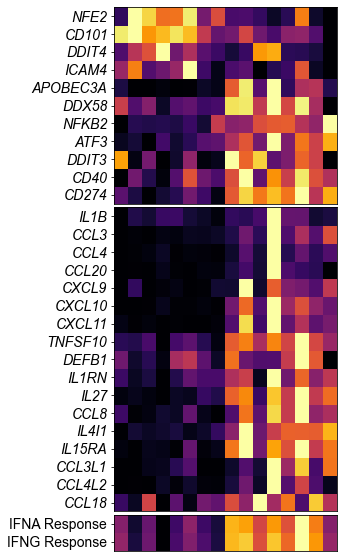

In [28]:
fig, axes = plt.subplots(
    nrows=3, 
    sharex=True, 
    figsize=(4, 10), 
    gridspec_kw={
        "height_ratios": [len(genes_of_i), len(cytokines), 2],
        "hspace": 0.02
    }
)
axes[0].pcolormesh(total_expr.loc[:, reversed(genes_of_i)].T.to_numpy(), cmap="inferno")
axes[0].set_yticks(pd.Series(range(len(genes_of_i))) + 0.5)
axes[0].set_yticklabels(
    reversed(genes_of_i), 
    fontstyle="italic",
    fontsize=14
)
troublemaker = axes[0].yaxis.get_majorticklabels()[9]
troublemaker.set_x(troublemaker._x + 0.006)
# troublemaker.set_y = lambda y: mpl.text.Text.set_y(troublemaker, y + 0)
axes[0].tick_params(bottom=False, labelbottom=False)

axes[1].pcolormesh(total_expr.loc[:, reversed(cytokines)].T.to_numpy(), cmap="inferno")
axes[1].set_yticks(pd.Series(range(len(cytokines))) + 0.5)
axes[1].set_yticklabels(reversed(cytokines), fontstyle="italic", fontsize=14)
axes[1].tick_params(bottom=False, labelbottom=False)

axes[2].pcolormesh(total_expr.loc[:, ["IFNG Response", "IFNA Response"]].T.to_numpy(), cmap="inferno")
axes[2].set_yticks([0.5, 1.5])
axes[2].set_yticklabels(["IFNG Response", "IFNA Response"], fontsize=14)
axes[2].tick_params(bottom=False, labelbottom=False)

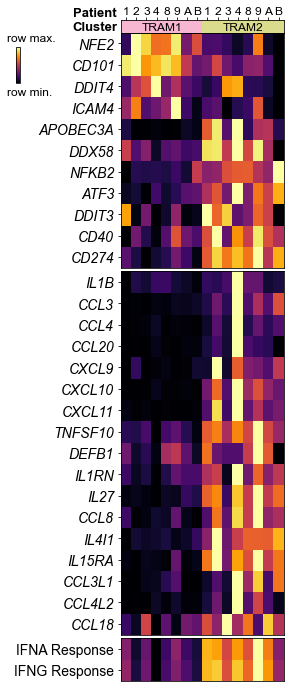

In [29]:
ax0bbox = axes[0].get_position()
labs = fig.add_axes((ax0bbox.x0, ax0bbox.y1, ax0bbox.width, 0.018), sharex=axes[0])
labs.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False, top=True, labeltop=True)
clusters = pd.Series(total_expr.index.str.split(",")).apply(lambda x: x[0]).value_counts().sort_index()
pats = pd.Series(total_expr.index.str.split(",")).apply(lambda x: x[1][4:])
s = 0
for i, n in enumerate(clusters.index):
    w = clusters[n]
    labs.add_patch(mpl.patches.Rectangle(
        (s, 0), 
        w, 
        1, 
        facecolor=palette.color[n]
    ))
    labs.annotate(
        n, 
        (w / 2 + s, 0.45),
        ha="center",
        va="center",
        color="black",
        fontsize=12
    )
    s += w
labs.set_xticks(pd.Series(range(pats.size)) + 0.5)
labs.set_xticklabels(pats), fontsize=12)
labs.tick_params(pad=0)
labs.annotate("Patient", (-0.4, 1.3), annotation_clip=False, ha="right", fontweight="bold", fontsize=13)
labs.annotate("Cluster", (-0.4, 0.2), annotation_clip=False, ha="right", fontweight="bold", fontsize=13)

cax = fig.add_axes((0.09, 0.81, 0.015, 0.05))
cax = fig.colorbar(
    mpl.cm.ScalarMappable(norm=None, cmap="inferno"),
    cax=cax,
    ticks=[]
)
cax.ax.annotate("row min.", (-2, -0.1), va="top", annotation_clip=False, fontsize=12)
cax.ax.annotate("row max.", (-2, 1.1), va="bottom", annotation_clip=False, fontsize=12)

available_height = axes[2].get_position().x0 + 0.02
proportions = [len(genes_of_i), len(cytokines), 2]
move = 0
for i, ax in enumerate(fig.axes):
    p = ax.get_position()
    if i == 4:
        p.x0 -= 0.05
        p.x1 -= 0.05
    else:
        p.x0 += 0.28
        p.x1 += 0.07
    p.y0 += 0.06
    p.y1 += 0.06
    if i < len(proportions):
        p.y1 -= move
        move += available_height / np.sum(proportions) * proportions[i]
        p.y0 -= move
    ax.set_position(p)

fig.savefig("07plots/5X_tram_markers.pdf")
fig

## Figure 5C: _IFNG_

../lib/script/scanpy.py:411: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


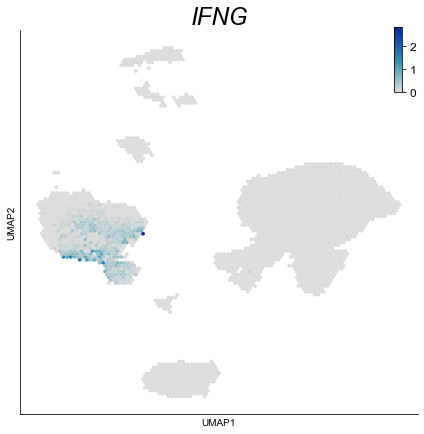

In [85]:
fig = sc_utils.feature_plot(covid, "IFNG", gridsize=(100, 60), linewidths=0.1, figsize=(6, 6))
fig.axes[0].set_title("IFNG", fontstyle="italic", fontsize=24)
fig.axes[1].yaxis.set_tick_params(labelsize=12)
fig.axes[1].yaxis.set_ticks([0, 1, 2])
fig.savefig("07plots/5C_IFNG.pdf")

## Figure 5D: n_sars_genes

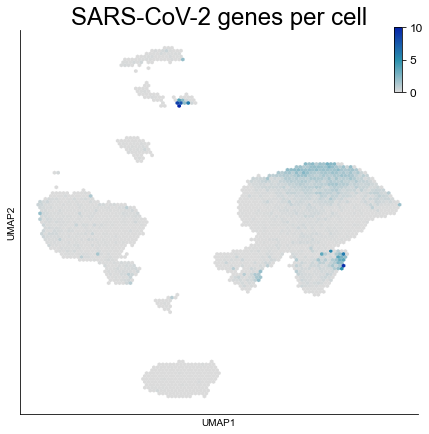

In [94]:
fig = sc_utils.feature_plot(covid, "n_sars_genes", gridsize=(100, 60), linewidths=0.1, figsize=(6, 6))
fig.axes[0].set_title("SARS-CoV-2 genes per cell", fontsize=24)
fig.axes[1].yaxis.set_tick_params(labelsize=12)
fig.axes[1].yaxis.set_ticks([0, 5, 10])
fig.savefig("07plots/5D_n_sars_genes.pdf")

## Figure 5E: _CCL20_

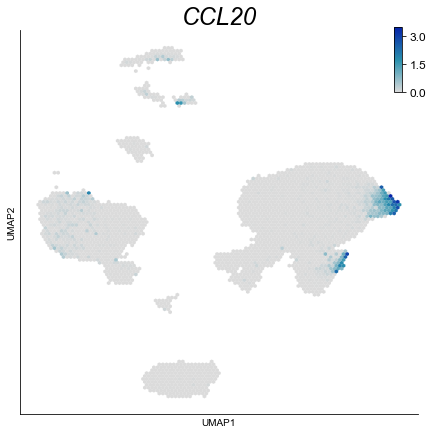

In [98]:
fig = sc_utils.feature_plot(covid, "CCL20", gridsize=(100, 60), linewidths=0.1, figsize=(6, 6))
fig.axes[0].set_title("CCL20", fontsize=24, fontstyle="italic")
fig.axes[1].yaxis.set_tick_params(labelsize=12)
fig.axes[1].yaxis.set_ticks([0, 1.5, 3])
fig.savefig("07plots/5E_CCL20.pdf")

## Figure 5F: _CCL4_

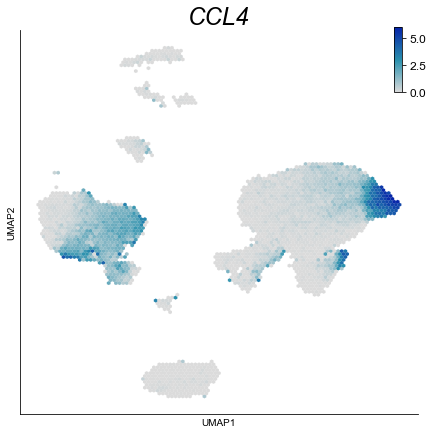

In [100]:
fig = sc_utils.feature_plot(covid, "CCL4", gridsize=(100, 60), linewidths=0.1, figsize=(6, 6))
fig.axes[0].set_title("CCL4", fontsize=24, fontstyle="italic")
fig.axes[1].yaxis.set_tick_params(labelsize=12)
fig.axes[1].yaxis.set_ticks([0, 2.5, 5])
fig.savefig("07plots/5F_CCL4.pdf")

## Figure 5XX: CXCL10

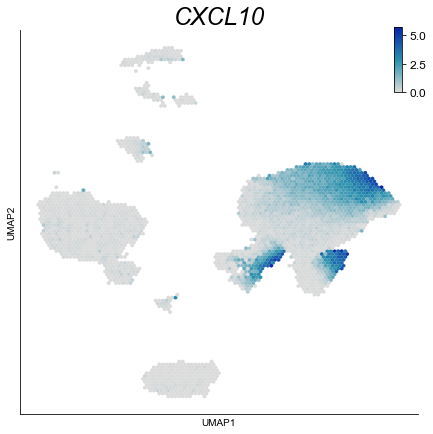

In [87]:
fig = sc_utils.feature_plot(covid, "CXCL10", gridsize=(100, 60), linewidths=0.1, figsize=(6, 6))
fig.axes[0].set_title("CXCL10", fontsize=24, fontstyle="italic")
fig.axes[1].yaxis.set_tick_params(labelsize=12)
fig.axes[1].yaxis.set_ticks([0, 2.5, 5])
fig.savefig("07plots/5XX_CXCL10.pdf")

## Figure 5G: _IL1B_

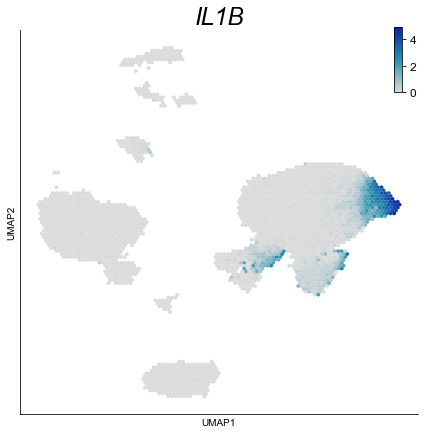

In [102]:
fig = sc_utils.feature_plot(covid, "IL1B", gridsize=(100, 60), linewidths=0.1, figsize=(6, 6))
fig.axes[0].set_title("IL1B", fontsize=24, fontstyle="italic")
fig.axes[1].yaxis.set_tick_params(labelsize=12)
fig.axes[1].yaxis.set_ticks([0, 2, 4])
fig.savefig("07plots/5G_IL1B.pdf")

## Figure 5H: _IFNG_ Response score

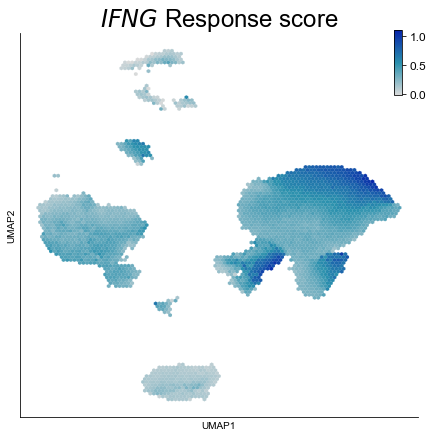

In [111]:
fig = sc_utils.feature_plot(covid, "IFNG Response", gridsize=(100, 60), figsize=(6, 6), linewidths=0.15)
fig.axes[0].set_title("$IFNG$ Response score", fontsize=24)
fig.axes[1].yaxis.set_tick_params(labelsize=12)
fig.axes[1].yaxis.set_ticks([0, 0.5, 1.0])
fig.savefig("07plots/5H_IFNG_response.pdf")

## Figure S6G: _IFNA_ Response score

../lib/script/scanpy.py:149: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


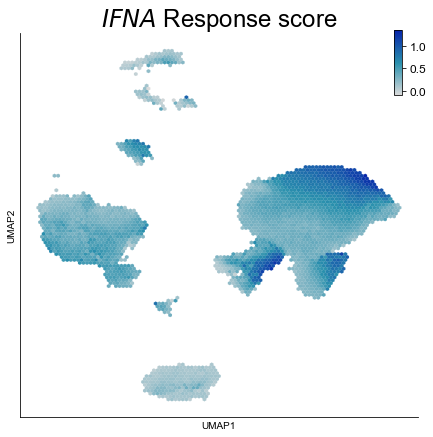

In [120]:
fig = sc_utils.feature_plot(covid, "IFNA Response", gridsize=(100, 60), figsize=(6, 6), linewidths=0.15)
fig.axes[0].set_title("$IFNA$ Response score", fontsize=24)
fig.axes[1].yaxis.set_tick_params(labelsize=12)
fig.axes[1].yaxis.set_ticks([0, 0.5, 1.0])
fig.savefig("07plots/S6G_IFNA_response.pdf")

## Figure S6C: SARS-CoV-2 negative strand

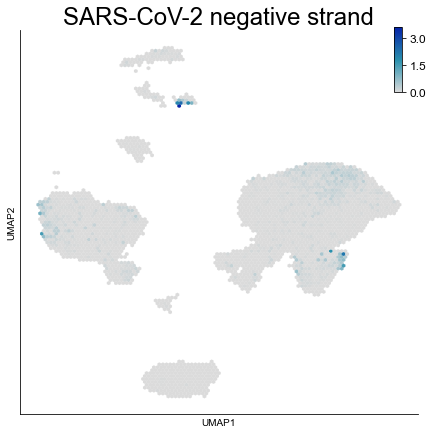

In [122]:
fig = sc_utils.feature_plot(covid, "SARS-CoV-2-Antisense", gridsize=(100, 60), figsize=(6, 6), linewidths=0.15)
fig.axes[0].set_title("SARS-CoV-2 negative strand", fontsize=24)
fig.axes[1].yaxis.set_tick_params(labelsize=12)
fig.axes[1].yaxis.set_ticks([0, 1.5, 3.0])
fig.savefig("07plots/S6C_sars_negative.pdf")

## Figure S5A: composition of Macrophage & T cells clusters

In [111]:
cluster_str = covid.obs.celltype.astype(str)
am_tcells = cluster_str[cluster_str.str.match("MoAM|TRAM|.*T cells|Treg")].unique()

In [112]:
am_tcells

array(['iNKT cells', 'CD8 cytotoxic T cells', 'MoAM2', 'CD4 CM T cells',
       'TRAM1', 'CD4 cytotoxic T cells', 'TRAM2', 'Treg', 'MoAM4',
       'CD8 cytotoxic TRM T cells', 'MoAM3', 'MoAM1',
       'CD4 proliferating T cells', 'CD8 proliferating T cells'],
      dtype=object)

Trying to set attribute `.obs` of view, copying.


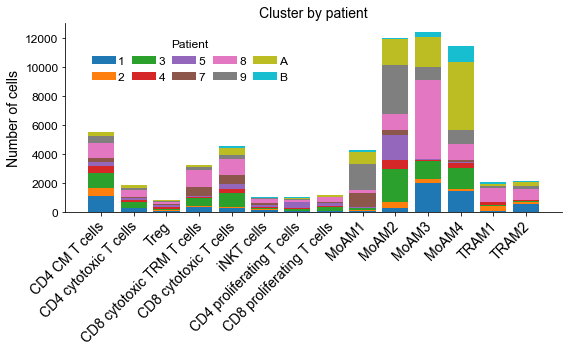

In [133]:
am_tcells_ds = covid[covid.obs.celltype.isin(am_tcells), :]
am_tcells_ds.obs.patient = am_tcells_ds.obs.patient.cat.set_categories(covid.obs.patient.cat.categories)
bottom = np.zeros(len(am_tcells_ds.obs.celltype.unique()))
fig, ax = plt.subplots(figsize=(8, 5))
for s in am_tcells_ds.obs.patient.cat.categories:
    cnt = am_tcells_ds.obs.celltype[am_tcells_ds.obs.patient == s].value_counts().sort_index()
    cnt = cnt.loc[[
        'CD4 CM T cells', 'CD4 cytotoxic T cells', 'Treg', 
        'CD8 cytotoxic TRM T cells', 'CD8 cytotoxic T cells', 'iNKT cells', 
        'CD4 proliferating T cells', 'CD8 proliferating T cells', 
        'MoAM1', 'MoAM2', 'MoAM3', 'MoAM4', 'TRAM1', 'TRAM2'
    ]]
    patient_num = am_tcells_ds.obs.patient[am_tcells_ds.obs.patient == s].values
    if len(patient_num) == 0:
        continue
    patient_num = patient_num[0]
    ax.bar(cnt.index, cnt.values, bottom=bottom, label=patient_num)
    bottom += cnt
ax.legend(
    title="Patient", 
    frameon=False, 
    fontsize=12, 
    title_fontsize=12, 
    loc="center", 
    bbox_to_anchor=(0.25, 0.8),
    ncol=5,
    columnspacing=0.6,
    handletextpad=0.2
)
ax.set_title("Cluster by patient", fontsize=14)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.tick_params(axis="x", labelsize=14, rotation=45)
ax.tick_params(axis="y", labelsize=12)
ax.set_xticklabels([
    'CD4 CM T cells', 'CD4 cytotoxic T cells', 'Treg', 
    'CD8 cytotoxic TRM T cells', 'CD8 cytotoxic T cells', 'iNKT cells', 
    'CD4 proliferating T cells', 'CD8 proliferating T cells', 
    'MoAM1', 'MoAM2', 'MoAM3', 'MoAM4', 'TRAM1',  'TRAM2'
], ha="right")
trans = mpl.transforms.Affine2D().translate(6, 0)
for t in ax.get_xticklabels():
    t.set_transform(t.get_transform() + trans)
ax.set_ylabel("Number of cells", fontsize=14)
ax.figure.tight_layout()
ax.figure.savefig("07plots/S5A_composition.pdf")

## Figure S5B: _IFNG_-expressing cells

Trying to set attribute `.obs` of view, copying.


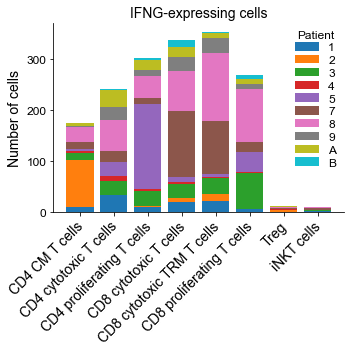

In [132]:
ifng_expr = covid.raw.X[:, covid.var_names == "IFNG"].A.reshape(-1)
tcells = cluster_str[cluster_str.str.match(".*T cells|Treg")].unique()
tcells_ds = covid[covid.obs.celltype.isin(tcells) & (ifng_expr > 0), :]
tcells_ds.obs.patient = tcells_ds.obs.patient.cat.set_categories(covid.obs.patient.cat.categories)
bottom = np.zeros(len(tcells_ds.obs.celltype.unique()))
fig, ax = plt.subplots(figsize=(5, 5))
for s in tcells_ds.obs.patient.cat.categories:
    cnt = tcells_ds.obs.celltype[tcells_ds.obs.patient == s].value_counts().sort_index()
    patient_num = tcells_ds.obs.patient[tcells_ds.obs.patient == s].values
    if len(patient_num) == 0:
        continue
    patient_num = patient_num[0]
    ax.bar(cnt.index, cnt.values, bottom=bottom, label=patient_num)
    bottom += cnt
ax.legend(
    title="Patient", 
    frameon=False, 
    fontsize=12, 
    title_fontsize=12, 
    labelspacing=0.2,
    loc="center",
    bbox_to_anchor=(0.9, 0.6)
)
ax.set_title("IFNG-expressing cells", fontsize=14)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.tick_params(axis="x", labelsize=14, rotation=45)
ax.tick_params(axis="y", labelsize=12)
ax.set_xticklabels(sorted(tcells), ha="right")
trans = mpl.transforms.Affine2D().translate(6, 0)
for t in ax.get_xticklabels():
    t.set_transform(t.get_transform() + trans)
ax.set_ylabel("Number of cells", fontsize=14)
ax.figure.tight_layout()
ax.figure.savefig("07plots/S5B_ifng_composition.pdf")

## Figure S6X: Coinfected patients

In [125]:
covid.obs["coinfected"] = covid.obs.patient.isin(["7", "A"]).astype("category")

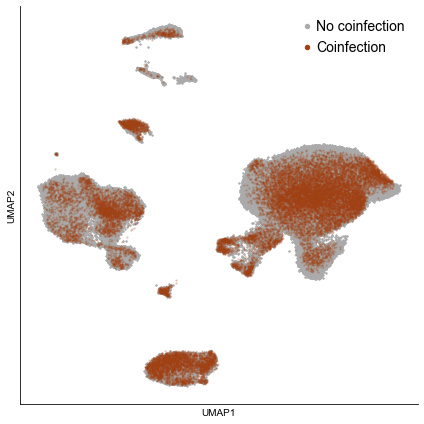

In [97]:
ax = plot_category_order(
    covid, 
    "coinfected",
    order=[False, True],
    palette=["#aaaaaa", "#a04114"],
    alphas=[1, 0.2],
    size=2
)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, ["No coinfection", "Coinfection"], frameon=False, fontsize=14, loc="upper right", handletextpad=-0.3)
for item in ax.get_legend().legendHandles:
    item.set_alpha(1)
    item.set_sizes([20])
ax.figure.tight_layout()
ax.figure.savefig("07plots/S6X_coinfection.pdf")

# All samples plots (Figure S6)

In [36]:
ds = sc.read_h5ad("../data/04dataset/04obj-manual.h5ad")

## Figure S5X: composition

Trying to set attribute `.obs` of view, copying.


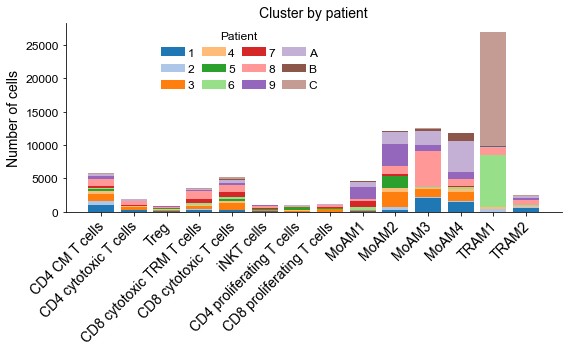

In [131]:
am_tcells_ds = ds[ds.obs.celltype.isin(am_tcells), :]
am_tcells_ds.obs.patient = am_tcells_ds.obs.patient.cat.set_categories(am_tcells_ds.obs.patient.cat.categories)
bottom = np.zeros(len(am_tcells_ds.obs.celltype.unique()))
fig, ax = plt.subplots(figsize=(8, 5))
ax.set_prop_cycle("color", list(mpl.cm.tab20.colors))
for s in am_tcells_ds.obs.patient.cat.categories:
    cnt = am_tcells_ds.obs.celltype[am_tcells_ds.obs.patient == s].value_counts().sort_index()
    cnt = cnt.loc[[
        'CD4 CM T cells', 'CD4 cytotoxic T cells', 'Treg', 
        'CD8 cytotoxic TRM T cells', 'CD8 cytotoxic T cells', 'iNKT cells', 
        'CD4 proliferating T cells', 'CD8 proliferating T cells', 
        'MoAM1', 'MoAM2', 'MoAM3', 'MoAM4', 'TRAM1', 'TRAM2'
    ]]
    patient_num = am_tcells_ds.obs.patient[am_tcells_ds.obs.patient == s].values
    if len(patient_num) == 0:
        continue
    patient_num = patient_num[0]
    ax.bar(cnt.index, cnt.values, bottom=bottom, label=patient_num)
    bottom += cnt
ax.legend(
    title="Patient", 
    frameon=False, 
    fontsize=12, 
    title_fontsize=12, 
    loc="center", 
    bbox_to_anchor=(0.35, 0.8),
    ncol=4,
    columnspacing=0.6,
    handletextpad=0.2
)
ax.set_title("Cluster by patient", fontsize=14)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.tick_params(axis="x", labelsize=14, rotation=45)
ax.tick_params(axis="y", labelsize=12)
ax.set_xticklabels([
    'CD4 CM T cells', 'CD4 cytotoxic T cells', 'Treg', 
    'CD8 cytotoxic TRM T cells', 'CD8 cytotoxic T cells', 'iNKT cells', 
    'CD4 proliferating T cells', 'CD8 proliferating T cells', 
    'MoAM1', 'MoAM2', 'MoAM3', 'MoAM4', 'TRAM1',  'TRAM2'
], ha="right")
trans = mpl.transforms.Affine2D().translate(6, 0)
for t in ax.get_xticklabels():
    t.set_transform(t.get_transform() + trans)
ax.set_ylabel("Number of cells", fontsize=14)
ax.figure.tight_layout()
ax.figure.savefig("07plots/S5XX_composition.pdf")

## Figure S6E: UMAP

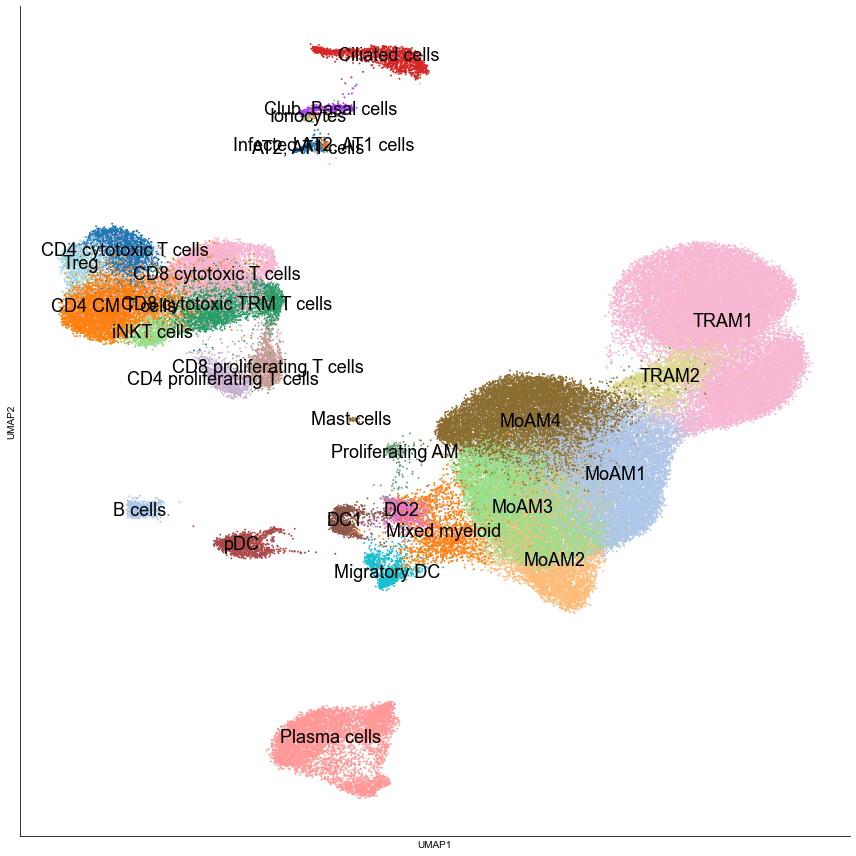

In [47]:
ax = sc.pl.umap(
    ds, 
    color="celltype", 
    size=15, 
    legend_loc="on data", 
    show=False, 
    legend_fontsize=18, 
    legend_fontweight="normal",
    palette=list(palette.fillna("#444444").color)
)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_title("")
ax.figure.tight_layout()
# ax.figure.savefig("07plots/S6E_umap_all.pdf")

## Figure S6F: Non-COVID patients

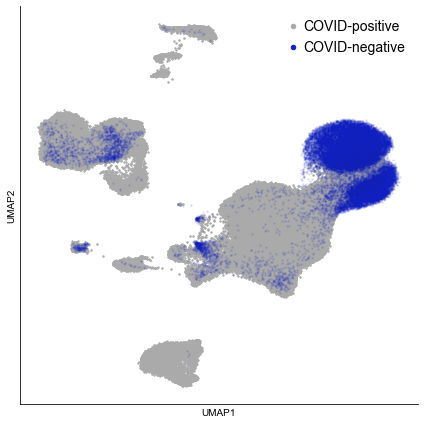

In [103]:
ax = plot_category_order(
    ds, 
    "COVID-19",
    order=["True", "False"],
    palette=["#aaaaaa", "#1020c0"],
    alphas=[1, 0.1],
    size=2
)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, ["COVID-positive", "COVID-negative"], frameon=False, fontsize=14, loc="upper right", handletextpad=-0.3)
for item in ax.get_legend().legendHandles:
    item.set_alpha(1)
    item.set_sizes([20])
ax.figure.tight_layout()
ax.figure.savefig("07plots/S6F_non-covid.pdf")

## Figure S6XX: diagnosis

In [91]:
def plot_category_order(ds, field, order=None, palette=None, alphas=None, figsize=(6, 6), size=15):
    fig, ax = plt.subplots(figsize=figsize)
    for i, val in enumerate(order):
        ax.scatter(
            ds.obsm["X_umap"][ds.obs[field] == val, 0],
            ds.obsm["X_umap"][ds.obs[field] == val, 1],
            s=size,
            c=palette[i],
            label=val,
            alpha=alphas and alphas[i] or 1,
        )
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.set_title("")
    ax.legend(frameon=False, fontsize=14)
    ax.set_xlabel("UMAP1")
    ax.set_ylabel("UMAP2")
    ax.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)
    return ax

In [250]:
ds.obs["diagnosis"] = "COVID-19"
ds.obs.loc[ds.obs.patient.isin(["6"]), "diagnosis"] = "Other Pneumonia"
ds.obs.loc[ds.obs.patient.isin(["C"]), "diagnosis"] = "Non-pneumonia Control"
ds.obs["diagnosis"] = ds.obs["diagnosis"].astype("category")

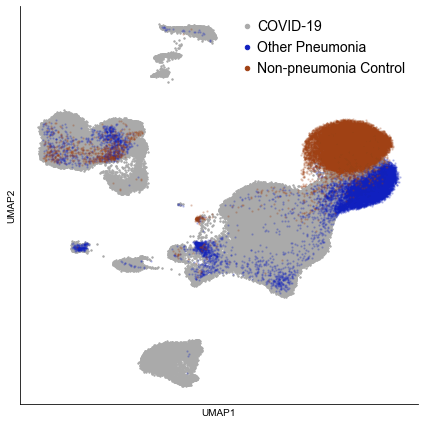

In [264]:
ax = plot_category_order(
    ds, 
    "diagnosis",
    order=["COVID-19", "Other Pneumonia", "Non-pneumonia Control"],
    palette=["#aaaaaa", "#1020c0", "#a04114"],
    alphas=[1, 0.2, 0.2],
    size=2
)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, frameon=False, fontsize=14, loc="upper right", handletextpad=-0.3)
for item in ax.get_legend().legendHandles:
    item.set_alpha(1)
    item.set_sizes([20])
ax.figure.tight_layout()
ax.figure.savefig("07plots/S6XX_diagnosis.pdf")

## Figure S6D: SARS-CoV-2 reads coverage

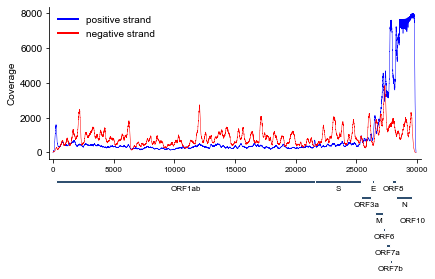

In [242]:
gtf = "../01human-sars-ref/NC_045512.2.gtf"
depth = "../data/03raw-data/sars-bam/combined.depth"

db = gffutils.create_db(gtf, ':memory:')
data = pd.read_table(depth, header=None)

line_height = 8
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(data[1], data[2], c="b", label="positive strand", lw=0.5)
ax.plot(data[1], data[5], c="r", label="negative strand", lw=0.5)
ax.legend(frameon=False)
for legobj in ax.get_legend().legendHandles:
    legobj.set_linewidth(2)
ax.set_ylabel("Coverage")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.tick_params(axis="x", labelsize=8)
ax.set_xlim(-300, 30300)
lines = []
fig.canvas.draw()
fig.subplots_adjust(left=0.11, right=0.97, top=0.98, bottom=0.45)
data_fig = ax.transData + fig.transFigure.inverted()
line_height = fig.transFigure.inverted().transform([0, line_height])[1]
for f in db.features_of_type("exon"):
    start = data_fig.transform([f.start, 0])[0]
    end = data_fig.transform([f.end, 0])[0]

    r = mpl.patches.Rectangle(
        (start, 0.45 - 3 * line_height),
        end - start,
        line_height * 0.4,
        fill=True,
        facecolor="#305070",
        linewidth=1,
        zorder=5,
        edgecolor="white"
    )
    fig.add_artist(r)
    rx, ry = r.get_xy()
    cx = rx + r.get_width() / 2
    cy = ry + r.get_height() / 2

    ann = mpl.text.Text(
        cx, cy,
        f.attributes["gene_name"][0],
        color="black",
        ha="center",
        va="top",
        fontsize=8,
        zorder=10
    )
    fig.add_artist(ann)

    rect_bb = r.get_window_extent()
    rect_bb = rect_bb.transformed(fig.transFigure.inverted())
    text_bb = ann.get_window_extent()
    text_bb = text_bb.transformed(fig.transFigure.inverted())
    margin = 0.01
    if len(lines) == 0:
        lines.append((rect_bb, text_bb))
    else:
        found = False
        for i, prev_bb in enumerate(lines):
            if prev_bb[0].x1 + margin < text_bb.x0 and prev_bb[1].x1 + margin < text_bb.x0:
                lines[i] = rect_bb, text_bb
                found = True
                break
        if not found:
            i = len(lines)
            lines.append((rect_bb, text_bb))
        if i > 0:
            r.set_y(r.get_y() - line_height * i * 2)
        ann.set_position((cx, cy - line_height * i * 2))
    ann_pos = ann.get_position()
    ann.set_position((ann_pos[0], ann_pos[1] - 0.5 * line_height))
fig.savefig("07plots/S6D_sars_reads.pdf")